# script to graph opentuner log

In [22]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
import pandas as pd
import numpy as np

# graph exec time vs. time in log file (--results-log-details)
def graph_log(log_name):
    data = pd.read_csv(log_name, sep=" ", names=["wallclock", "exectime"])
    plt.plot(data["wallclock"], data["exectime"], '-+', label='tuned', linewidth=1)
    plt.xlabel("Tuning Time (s)")
    plt.ylabel("Execution Time (s)")
    plt.legend()
    plt.show()

In [23]:
# graph exec time vs. tuning time in log file (--results-log-details)
def graph_tuning(log_name, mesh2d=0.0, mesh3d=0.0, torus2d=0.0, torus3d=0.0, axis="time", last=0):
    data = pd.read_csv(log_name, sep=" ", names=["wallclock", "exectime"])
    best_times = []
    best_time = data["exectime"][0]
    best_times.append(best_time)
    worst_time = 0.0
    for i in range(1, len(data["exectime"])):
        if data["exectime"][i] < best_time:
            best_time = data["exectime"][i]
        best_times.append(best_time)
    if mesh2d > 0.0:
        plt.axhline(y=mesh2d, xmin=0, xmax=1, linestyle='-', linewidth=1, color='red', label='2dmesh')
    if mesh3d > 0.0:
        plt.axhline(y=mesh3d, xmin=0, xmax=1, linestyle='-', linewidth=1, color='blue', label='3dmesh')  
    if torus2d > 0.0:
        plt.axhline(y=torus2d, xmin=0, xmax=1, linestyle='-', linewidth=1, color='green', label='2dtorus')   
    if torus3d > 0.0:
        plt.axhline(y=torus3d, xmin=0, xmax=1, linestyle='-', linewidth=1, color='brown', label='3dtorus')     
    max_time = max(data["exectime"][0], mesh2d, mesh3d, torus2d, torus3d)
    min_time = min(best_time, mesh2d, mesh3d, torus2d, torus3d)
    if min_time == 0:
        min_time = best_time
    ax = plt.gca()
    ax.spines['left'].set_color('black')
    ax.spines['left'].set_linewidth(1)
    ax.spines['right'].set_color('black')
    ax.spines['right'].set_linewidth(1)
    ax.spines['top'].set_color('black')
    ax.spines['top'].set_linewidth(1)
    ax.spines['bottom'].set_color('black')
    ax.spines['bottom'].set_linewidth(1)
    if last > 0:
        plt.xlim((0, last))
    if axis == "id":
        plt.plot(range(1, len(data)+1), best_times, '^-', label='tuned', color='black', linewidth=1, markersize=8)
        plt.xlabel("Number of Tests")
    else:
        plt.plot(data["wallclock"], best_times, '^-', label='tuned', color='black', linewidth=1, markersize=8)
        plt.xlabel("Tuning Time (s)")
    plt.ylabel("Execution Time (s)")
    plt.ylim(top=max_time+(max_time-min_time)*0.4, bottom=min_time*0.8)
    plt.tick_params(top=True, bottom=True, left=True, right=True, direction='in')
    plt.tick_params(which='major', length=4)
    plt.grid(False)
    plt.legend(frameon=False, fontsize=12, loc='upper right', ncol=3)
    # plt.savefig(log_name+'.eps', bbox_inches='tight', transparent=True)
    plt.show()

In [24]:
from matplotlib.ticker import PercentFormatter
# percentage of tuning tests required to get close to the optimal execution time within the tuning period
def graph_tests(**logs): #dict logs={AAA:"xxx", BBB:"yyy", CCC:"zzz"}
    C1 = []
    C2 = []
    C3 = []
    for appname, logname in logs.items():
        data = pd.read_csv(logname, sep=" ", names=["wallclock", "exectime"])
        tmin = min(data["exectime"])
        ntests = len(data["exectime"])
        R1 = 0.0
        R2 = 0.0
        R3 = 0.0
        for i in range(ntests):
            if R1 == 0.0 and 1 - (data["exectime"][i] - tmin)/tmin > 0.7:
                R1 = (i+1)/ntests
            if R2 == 0.0 and 1 - (data["exectime"][i] - tmin)/tmin > 0.8:
                R2 = (i+1)/ntests
            if R3 == 0.0 and 1 - (data["exectime"][i] - tmin)/tmin > 0.9:
                R3 = (i+1)/ntests
                break
        C1.append(R1)
        C2.append(R2)
        C3.append(R3)
    # plot data in grouped manner of bar type
    x = np.arange(len(logs)) # different from range(), can subtract -
    width = 0.3
    plt.bar(x-width, C1, width, color='cyan')
    plt.bar(x, C2, width, color='orange')
    plt.bar(x+width, C3, width, color='green')
    for a, b in list(zip(x-width, C1)) + list(zip(x, C2)) + list(zip(x+width, C3)):
        plt.text(a, b, '%.0f%%'%(b*100), ha="center", va="bottom", fontsize=8)
    plt.xticks(x, list(logs.keys()))
    plt.xlabel("Applications")
    plt.ylabel("Percentage of Tests")
    plt.legend(["C = 70%", "C = 80%", "C = 90%"])
    ax = plt.gca()
    ax.spines['left'].set_color('black')
    ax.spines['left'].set_linewidth(1)
    ax.spines['right'].set_color('black')
    ax.spines['right'].set_linewidth(1)
    ax.spines['top'].set_color('black')
    ax.spines['top'].set_linewidth(1)
    ax.spines['bottom'].set_color('black')
    ax.spines['bottom'].set_linewidth(1)
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0, decimals=0))
    # plt.savefig('tests.eps', bbox_inches='tight', transparent=True)
    plt.show()

# graph_tests(CG="cg.A.64.log", MG="mg.A.64.log", FT="ft.A.64.log", MM="gemm.64.log", Graph500="graph500.64.log")

In [25]:
# speedup within the tuning period
def graph_speedup(**logs): #dict logs={AAA:"xxx", BBB:"yyy", CCC:"zzz"}
    S = []
    for appname, logname in logs.items():
        data = pd.read_csv(logname, sep=" ", names=["wallclock", "exectime"])
        tmin = min(data["exectime"])
        tini = data["exectime"][0]
        speedup = (tini-tmin)/tini
        S.append(speedup)
    S.append(np.mean(S))
    # plot data in grouped manner of bar type
    x = np.arange(len(logs)+1) # different from range(), can subtract -
    width = 0.8
    plt.bar(x, S, width, color='steelblue')
    for a, b in zip(x, S):
        plt.text(a, b, '%.1f%%'%(b*100), ha="center", va="bottom", fontsize=12)
    appnames = list(logs.keys())
    appnames.append("Avg")
    plt.xticks(x, appnames)
    plt.xlabel("Applications")
    plt.ylabel("Speedup")
    ax = plt.gca()
    ax.spines['left'].set_color('black')
    ax.spines['left'].set_linewidth(1)
    ax.spines['right'].set_color('black')
    ax.spines['right'].set_linewidth(1)
    ax.spines['top'].set_color('black')
    ax.spines['top'].set_linewidth(1)
    ax.spines['bottom'].set_color('black')
    ax.spines['bottom'].set_linewidth(1)
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0, decimals=0))
    plt.ylim(top=0.7)
    # plt.savefig('speedup.eps', bbox_inches='tight', transparent=True)
    plt.show()        

# graph_speedup(CG="cg.A.64.log", MG="mg.A.64.log", FT="ft.A.64.log", MM="gemm.64.log", Graph500="graph500.64.log")

# result of BT

# result of CG

# result of LU

# result of MG

# result of SP

# result of FT

# result of MM

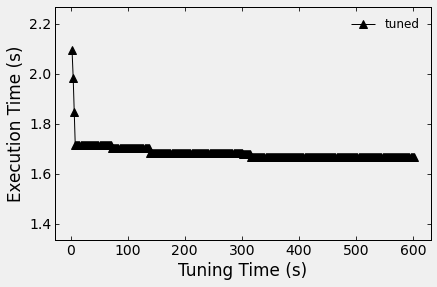

In [26]:
graph_tuning("mm8.log")

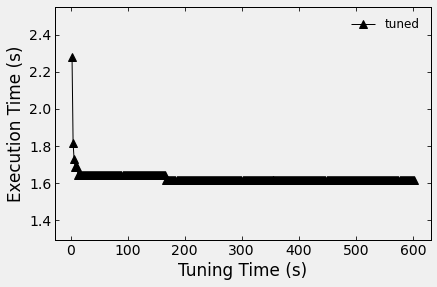

In [27]:
graph_tuning("mm16.log")

# Graph500 (64 8)

# Himeno (S)

# K-means